In [1]:
!pip install imutils
!pip install efficientnet



  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=6e290935a7fb3f0c006b819c18bf949ee1dcc9599bf1ab90e2040b7f752369ef
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 832.7 kB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')


2024-03-08 05:58:28.513265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 05:58:28.513368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 05:58:28.694116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from pathlib import Path

img_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
image_dir = Path(img_dir)
filepaths = list(image_dir.glob(r'**/*.png'))

labels = []
for filepath in filepaths:
    label = os.path.split(os.path.split(filepath)[0])[1]
    labels.append(label)


In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac=1).reset_index(drop = True)

df.head(4)
df['Label'].value_counts()

Label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

In [5]:
import plotly.express as px

Class_series = pd.Series(df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_sequence=["skyblue", "black", "pink", "purple", "blue"],
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})  
fig.show()

In [7]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(df['Label'])
df['Label']=labelEncoder.transform(df['Label'])

In [14]:
from sklearn.utils import resample

n_samples = 400
label_counts = df['Label'].value_counts()
dfs_by_label_resampled = {}

# Iterate through each label
for label in range(5):    
    # Check if there are enough samples for resampling
    if label_counts[label] < n_samples:
        # If there are not enough samples, duplicate the existing ones to reach 400
        df_label_resampled = pd.concat([df[df['Label'] == label]] * ((n_samples + label_counts[label] - 1) // label_counts[label]))
        df_label_resampled = df_label_resampled.sample(n_samples, replace=True, random_state=42)
    else:
        # If there are enough samples, resample to get exactly 400
        df_label_resampled = resample(df[df['Label'] == label], n_samples=n_samples, replace=True, random_state=42)
    
    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

# Concatenate the resampled DataFrames
balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['Label'].value_counts()


Label
4    400
0    400
3    400
2    400
1    400
Name: count, dtype: int64

In [15]:
import plotly.express as px

Class_series = pd.Series(balanced_df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_sequence=["skyblue", "black", "pink", "purple", "blue"],
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})  
fig.show()

In [21]:
directory = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'

# Create a pattern to access all PNG files in the directory
pattern = os.path.join(directory, '*', '*.png')

# Use glob to get all file paths matching the pattern
image_paths = glob(pattern)

size = (224, 224)


def load_image_and_resize(filepath):
        img = Image.open(filepath)
        img = img.resize(size)
        img = np.asarray(img)
        return img

balanced_df['image'] = balanced_df['Filepath'].map(lambda x: load_image_and_resize(x))


In [23]:
balanced_df['image']

0       [[[128, 128, 128], [128, 128, 128], [128, 128,...
1       [[[128, 128, 128], [128, 128, 128], [128, 128,...
2       [[[121, 125, 125], [129, 129, 129], [128, 128,...
3       [[[128, 128, 128], [128, 128, 128], [128, 128,...
4       [[[128, 128, 128], [128, 128, 128], [124, 124,...
                              ...                        
1995    [[[129, 129, 129], [130, 130, 125], [128, 127,...
1996    [[[128, 128, 128], [125, 131, 128], [128, 132,...
1997    [[[128, 128, 128], [128, 128, 128], [128, 128,...
1998    [[[128, 128, 128], [128, 128, 128], [130, 130,...
1999    [[[128, 128, 128], [128, 128, 128], [139, 139,...
Name: image, Length: 2000, dtype: object

In [22]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
sampled_images = balanced_df['image'].sample(6, random_state=42)
size = (224, 224)
sampled_images = [Image.fromarray(img).resize(size) for img in sampled_images]

sampled_images = [np.array(img) for img in sampled_images]

fig = make_subplots(rows=2, cols=3, subplot_titles=("Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6"))

for i, img in enumerate(sampled_images, start=1):
    fig.add_trace(go.Image(z=img), row=(i-1) // 3 + 1, col=(i-1) % 3 + 1)

fig.update_layout(
    title="Sample Images",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)

fig.show()

In [29]:
from keras.utils import to_categorical
x=np.asarray(balanced_df['image'].to_list())
x=x/255
y=balanced_df['Label']
y=to_categorical(y,num_classes=5)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42,shuffle=True)

In [30]:
x

array([[[[0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         ...,
         [0.48627451, 0.50196078, 0.50196078],
         [0.49803922, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078]],

        [[0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         ...,
         [0.50196078, 0.51764706, 0.50196078],
         [0.49019608, 0.50588235, 0.49019608],
         [0.48627451, 0.50196078, 0.48627451]],

        [[0.50588235, 0.49019608, 0.49019608],
         [0.49803922, 0.50980392, 0.49803922],
         [0.50196078, 0.50196078, 0.50196078],
         ...,
         [0.51764706, 0.50196078, 0.50196078],
         [0.51764706, 0.50196078, 0.50196078],
         [0.49803922, 0.50980392, 0.49803922]],

        ...,

        [[0.50980392, 0.50980392, 0.50980392],
         [0.49803922, 0.49019608, 0.50196078]

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from keras.callbacks import EarlyStopping


es = EarlyStopping(monitor='val_accuracy', min_delta = 0.005, patience=10, verbose=1, mode='auto')
vgg = DenseNet121(input_shape=(224,224,3),weights='imagenet',include_top=False)
vgg.trainable = False
x = Flatten()(vgg.output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.4)(x)

prediction = Dense(5,activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train ,
                    y_train ,
                    epochs=70 ,
                    batch_size=8,
                    validation_data=(x_test , y_test) ,
                    callbacks=es
                    )


Epoch 1/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.4017 - loss: 2.1550 - val_accuracy: 0.5175 - val_loss: 1.1337
Epoch 2/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5279 - loss: 1.1331 - val_accuracy: 0.6325 - val_loss: 0.9763
Epoch 3/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5762 - loss: 0.9895 - val_accuracy: 0.6550 - val_loss: 0.9298
Epoch 4/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6139 - loss: 0.9338 - val_accuracy: 0.6525 - val_loss: 0.9084
Epoch 5/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6424 - loss: 0.8805 - val_accuracy: 0.6850 - val_loss: 0.8804
Epoch 6/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6564 - loss: 0.8346 - val_accuracy: 0.6975 - val_loss: 0.8649
Epoch 7/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7115 - loss: 0.7574 - val_accuracy: 0.7350 - val_loss: 0.8021
Epoch 8/70
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6952 - loss: 0.7193 - val_acc

In [64]:
loss, accuracy = model.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8385 - loss: 0.7320
Test Loss: 0.660307765007019
Test Accuracy: 0.8399999737739563


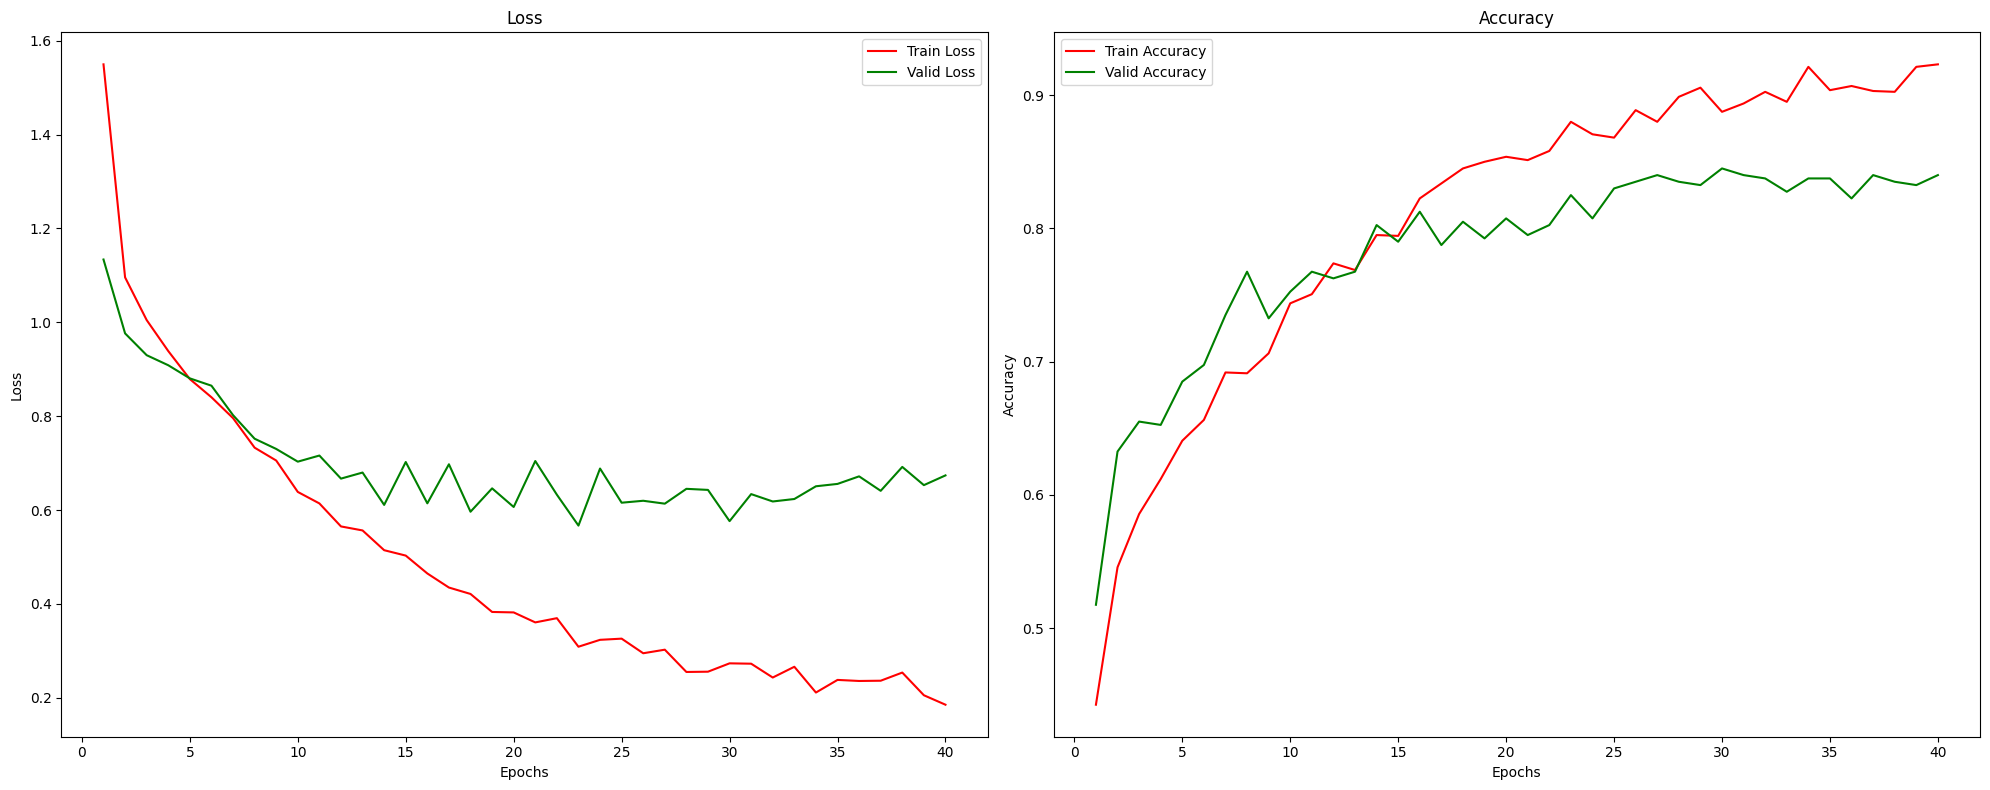

In [63]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()